# Intent Recognition with BERT using Keras and TensorFlow 2

In [1]:
!pip install tensorflow==2.2.0-rc1
!pip install --upgrade grpcio
!pip install tqdm
!pip install bert-for-tf2
!pip install sentencepiece

Requirement already up-to-date: grpcio in /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages (1.27.2)
Requirement already up-to-date: grpcio in /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages (1.27.2)


In [2]:
import tensorflow as tf
print(tf.__version__)

2.2.0-rc1
2.2.0-rc1


In [3]:
import boto3
import sagemaker
import pandas as pd

sess   = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

sm = boto3.Session().client(service_name='sagemaker', region_name=region)

In [4]:
import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Data

The data contains various user queries categorized into seven intents. It is hosted on [GitHub](https://github.com/snipsco/nlu-benchmark/tree/master/2017-06-custom-intent-engines) and is first presented in [this paper](https://arxiv.org/abs/1805.10190).

In [5]:
%store -r scikit_processing_job_s3_output_prefix

In [6]:
print('Previous Scikit Processing Job Name: {}'.format(scikit_processing_job_s3_output_prefix))

Previous Scikit Processing Job Name: sagemaker-scikit-learn-2020-03-27-05-28-30-227
Previous Scikit Processing Job Name: sagemaker-scikit-learn-2020-03-27-05-28-30-227


In [7]:
# prefix_train = '{}/output/bert-train'.format(scikit_processing_job_s3_output_prefix)
# prefix_validation = '{}/output/bert-validation'.format(scikit_processing_job_s3_output_prefix)
# prefix_test = '{}/output/bert-test'.format(scikit_processing_job_s3_output_prefix)

# path_train = './{}'.format(prefix_train)
# path_validation = './{}'.format(prefix_validation)
# path_test = './{}'.format(prefix_test)

# train_s3_uri = 's3://{}/{}'.format(bucket, prefix_train)
# validation_s3_uri = 's3://{}/{}'.format(bucket, prefix_validation)
# test_s3_uri = 's3://{}/{}'.format(bucket, prefix_test)

In [8]:
# s3_input_train_data = sagemaker.s3_input(s3_data=train_s3_uri) #, content_type='text/csv')
# s3_input_validation_data = sagemaker.s3_input(s3_data=validation_s3_uri) #, content_type='text/csv')
# s3_input_test_data = sagemaker.s3_input(s3_data=test_s3_uri) #, content_type='text/csv')

# print(s3_input_train_data.config)
# print(s3_input_validation_data.config)
# print(s3_input_test_data.config)

In [9]:
# !aws s3 cp --recursive $train_s3_uri $path_train
# !aws s3 cp --recursive $validation_s3_uri $path_validation
# !aws s3 cp --recursive $test_s3_uri $path_test

In [10]:
train = pd.read_csv('./data/amazon_reviews_us_Digital_Software_v1_00.tsv.gz', delimiter='\t')[:100]
#valid = pd.read_csv("valid.csv")
test = pd.read_csv('./data/amazon_reviews_us_Digital_Software_v1_00.tsv.gz', delimiter='\t')[:100]

In [11]:
#train = train.append(valid).reset_index(drop=True)

In [12]:
train.shape

(100, 15)

(100, 15)

In [13]:
train.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,17747349,R2EI7QLPK4LF7U,B00U7LCE6A,106182406,CCleaner Free [Download],Digital_Software,4,0,0,N,Y,Four Stars,So far so good,2015-08-31
1,US,10956619,R1W5OMFK1Q3I3O,B00HRJMOM4,162269768,ResumeMaker Professional Deluxe 18,Digital_Software,3,0,0,N,Y,Three Stars,Needs a little more work.....,2015-08-31
2,US,13132245,RPZWSYWRP92GI,B00P31G9PQ,831433899,Amazon Drive Desktop [PC],Digital_Software,1,1,2,N,Y,One Star,Please cancel.,2015-08-31
3,US,35717248,R2WQWM04XHD9US,B00FGDEPDY,991059534,Norton Internet Security 1 User 3 Licenses,Digital_Software,5,0,0,N,Y,Works as Expected!,Works as Expected!,2015-08-31
4,US,17710652,R1WSPK2RA2PDEF,B00FZ0FK0U,574904556,SecureAnywhere Intermet Security Complete 5 De...,Digital_Software,4,1,2,N,Y,Great antivirus. Worthless customer support,I've had Webroot for a few years. It expired a...,2015-08-31


,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,17747349,R2EI7QLPK4LF7U,B00U7LCE6A,106182406,CCleaner Free [Download],Digital_Software,4,0,0,N,Y,Four Stars,So far so good,2015-08-31
1,US,10956619,R1W5OMFK1Q3I3O,B00HRJMOM4,162269768,ResumeMaker Professional Deluxe 18,Digital_Software,3,0,0,N,Y,Three Stars,Needs a little more work.....,2015-08-31
2,US,13132245,RPZWSYWRP92GI,B00P31G9PQ,831433899,Amazon Drive Desktop [PC],Digital_Software,1,1,2,N,Y,One Star,Please cancel.,2015-08-31
3,US,35717248,R2WQWM04XHD9US,B00FGDEPDY,991059534,Norton Internet Security 1 User 3 Licenses,Digital_Software,5,0,0,N,Y,Works as Expected!,Works as Expected!,2015-08-31
4,US,17710652,R1WSPK2RA2PDEF,B00FZ0FK0U,574904556,SecureAnywhere Intermet Security Complete 5 De...,Digital_Software,4,1,2,N,Y,Great antivirus. Worthless customer support,I've had Webroot for a few years. It expired a...,2015-08-31


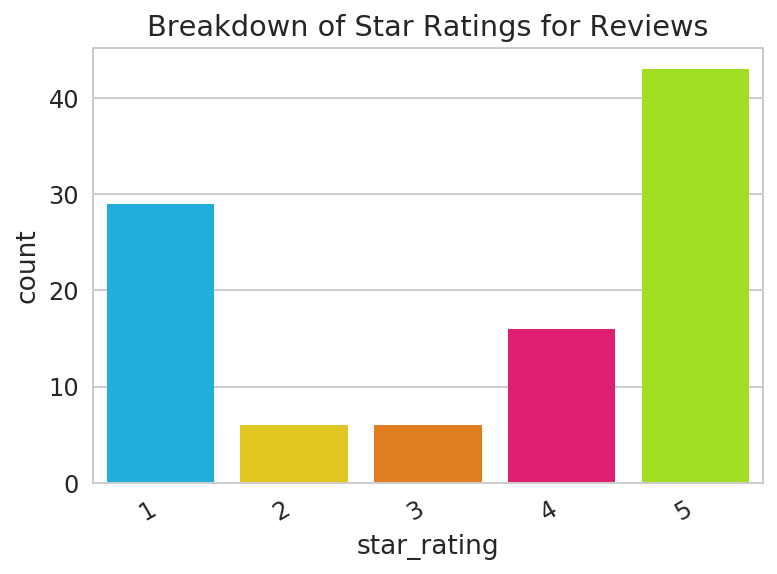

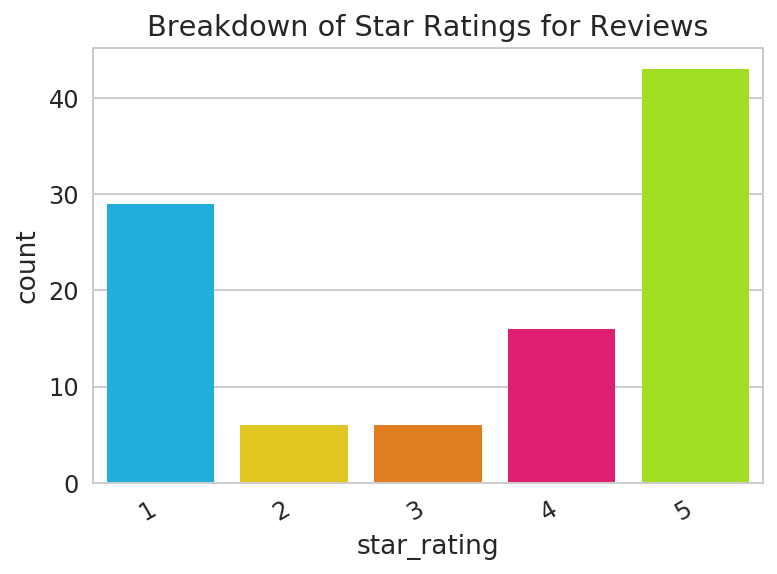

In [14]:
chart = sns.countplot(train.star_rating, palette=HAPPY_COLORS_PALETTE)
plt.title("Breakdown of Star Ratings for Reviews")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

# Multi-Class Classification with BERT

In [15]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip

--2020-03-28 06:30:40--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.13.240, 2607:f8b0:4004:804::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.13.240|:443... connected.
HTTP request sent, awaiting response... --2020-03-28 06:30:40--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.13.240, 2607:f8b0:4004:804::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.13.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

          uncased_L   0%[                    ]       0  --.-KB/s               200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 

In [16]:
!unzip -f uncased_L-12_H-768_A-12.zip
!ls -al ./model/uncased_L-12_H-768_A-12

Archive:  uncased_L-12_H-768_A-12.zip
Archive:  uncased_L-12_H-768_A-12.zip
total 431244
drwxr-xr-x 2 ec2-user ec2-user      4096 Nov  1  2018 .
drwxrwxr-x 3 ec2-user ec2-user      4096 Mar 28 05:38 ..
-rw-r--r-- 1 ec2-user ec2-user       313 Oct 18  2018 bert_config.json
-rw-r--r-- 1 ec2-user ec2-user 440425712 Oct 18  2018 bert_model.ckpt.data-00000-of-00001
-rw-r--r-- 1 ec2-user ec2-user      8528 Oct 18  2018 bert_model.ckpt.index
-rw-r--r-- 1 ec2-user ec2-user    904243 Oct 18  2018 bert_model.ckpt.meta
-rw-r--r-- 1 ec2-user ec2-user    231508 Oct 18  2018 vocab.txt
total 431244
drwxr-xr-x 2 ec2-user ec2-user      4096 Nov  1  2018 .
drwxrwxr-x 3 ec2-user ec2-user      4096 Mar 28 05:38 ..
-rw-r--r-- 1 ec2-user ec2-user       313 Oct 18  2018 bert_config.json
-rw-r--r-- 1 ec2-user ec2-user 440425712 Oct 18  2018 bert_model.ckpt.data-00000-of-00001
-rw-r--r-- 1 ec2-user ec2-user      8528 Oct 18  2018 bert_model.ckpt.index
-rw-r--r-- 1 ec2-user ec2-user    904243 Oct 18  2018 bert_

In [17]:
bert_ckpt_dir = './model/uncased_L-12_H-768_A-12'
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

## Preprocessing

In [18]:
class ClassificationData:
  TEXT_COLUMN = 'review_body'
  LABEL_COLUMN = 'star_rating'

  def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    self.classes = classes
    
    ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

#    print('max seq_len', self.max_seq_len)
    self.max_seq_len = min(self.max_seq_len, max_seq_len)
    self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

  def _prepare(self, df):
    x, y = [], []
    
    for _, row in tqdm(df.iterrows()):
      text, label = row[ClassificationData.TEXT_COLUMN], row[ClassificationData.LABEL_COLUMN]
      tokens = self.tokenizer.tokenize(text)
      tokens = ["[CLS]"] + tokens + ["[SEP]"]
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      self.max_seq_len = max(self.max_seq_len, len(token_ids))
      x.append(token_ids)
      y.append(self.classes.index(label))

    return np.array(x), np.array(y)

  def _pad(self, ids):
    x = []
    for input_ids in ids:
      input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
      x.append(np.array(input_ids))
    return np.array(x)

In [19]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))

In [20]:
tokenizer.tokenize("I can't wait to visit Bulgaria again!")

['i', 'can', "'", 't', 'wait', 'to', 'visit', 'bulgaria', 'again', '!']

['i', 'can', "'", 't', 'wait', 'to', 'visit', 'bulgaria', 'again', '!']

In [21]:
tokens = tokenizer.tokenize("I can't wait to visit Bulgaria again!")
tokenizer.convert_tokens_to_ids(tokens)

[1045, 2064, 1005, 1056, 3524, 2000, 3942, 8063, 2153, 999]

[1045, 2064, 1005, 1056, 3524, 2000, 3942, 8063, 2153, 999]

In [22]:
def create_model(max_seq_len, bert_ckpt_file):

  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
      bc = StockBertConfig.from_json_string(reader.read())
      bert_params = map_stock_config_to_params(bc)
      bert_params.adapter_size = None
      bert = BertModelLayer.from_params(bert_params, name="bert")
        
  input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
  bert_output = bert(input_ids)

  print("bert shape", bert_output.shape)

  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
  cls_out = keras.layers.Dropout(0.5)(cls_out)
  logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
  logits = keras.layers.Dropout(0.5)(logits)
  logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)

  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape=(None, max_seq_len))

  load_stock_weights(bert, bert_ckpt_file)
        
  return model

## Training

In [23]:
import numpy as np

classes = train['star_rating'].unique().tolist()
classes

[4, 3, 1, 5, 2]

[4, 3, 1, 5, 2]

In [24]:
features = ClassificationData(train, test, tokenizer, classes, max_seq_len=128)

100it [00:00, 1933.25it/s]
0it [00:00, ?it/s]
100it [00:00, 1944.92it/s]
100it [00:00, 1944.92it/s]


In [25]:
features.train_x.shape

(100, 128)

(100, 128)

In [26]:
features.train_x[0]

array([ 101, 2061, 2521, 2061, 2204,  102,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0])

array([ 101, 2061, 2521, 2061, 2204,  102,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0])

In [27]:
features.train_y[0]

0

0

In [28]:
features.max_seq_len

128

128

In [29]:
model = create_model(features.max_seq_len, bert_ckpt_file)

bert shape (None, 128, 768)
bert shape (None, 128, 768)
Done loading 196 BERT weights from: ./model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fe320c5f240> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Done loading 196 BERT weights from: ./model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fe320c5f240> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddin

In [30]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 128)]             0         
_________________________________________________________________
bert (BertModelLayer)        (None, 128, 768)          108890112 
_________________________________________________________________
lambda (Lambda)              (None, 768)               0         
_________________________________________________________________
dropout (Dropout)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 768)               590592    
_________________________________________________________________
dropout_1 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 3845  

In [31]:
model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

In [32]:
log_dir = "log/classification/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

history = model.fit(
  x=features.train_x, 
  y=features.train_y,
  validation_split=0.1,
  batch_size=8,
  shuffle=False,
  epochs=1,
  callbacks=[tensorboard_callback]
)

12/12 [==============================] - 22s 2s/step - loss: 1.5680 - acc: 0.2556 - val_loss: 1.4677 - val_acc: 0.4000


## Evaluation

In [33]:
#%load_ext tensorboard

In [34]:
#%tensorboard --logdir log/

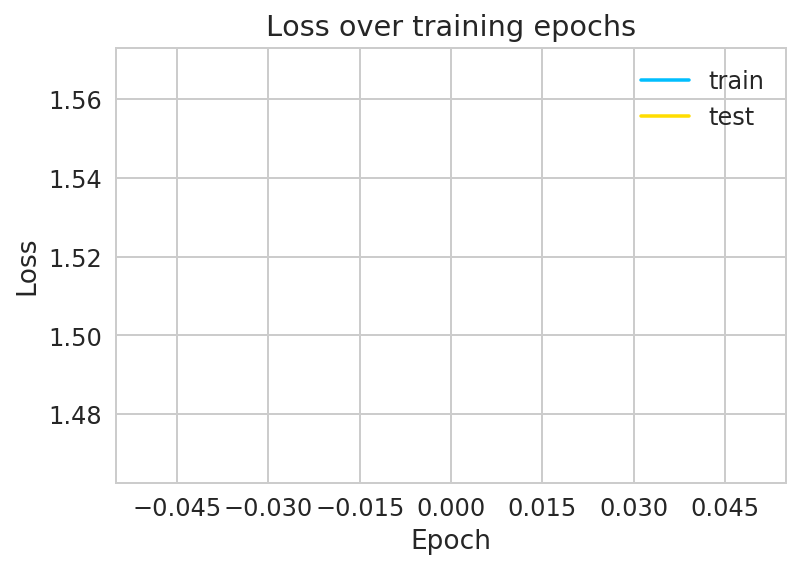

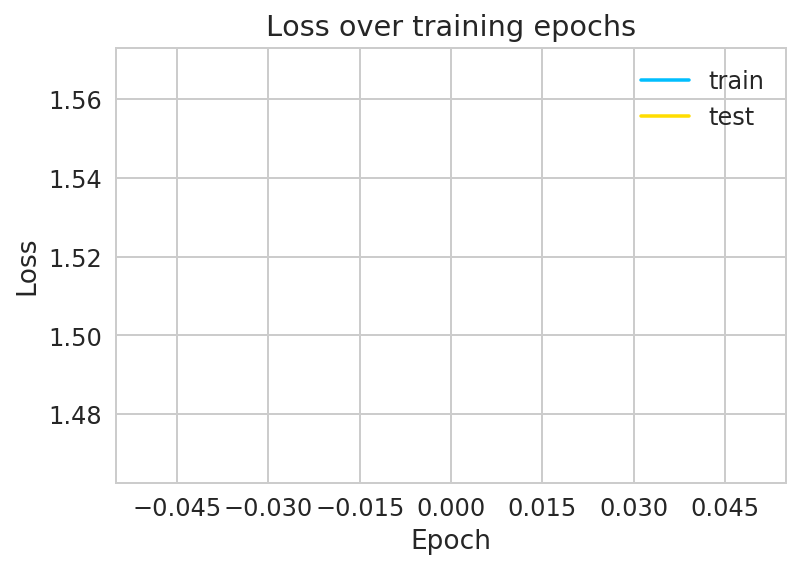

In [35]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

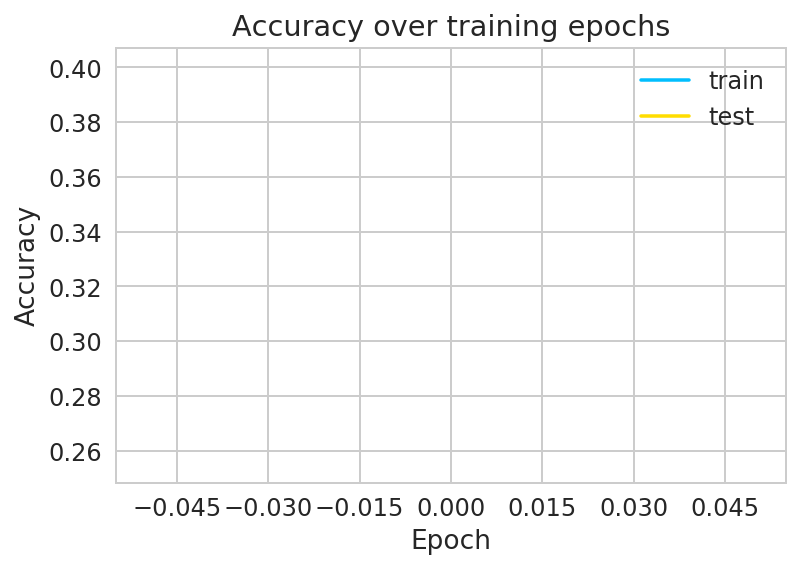

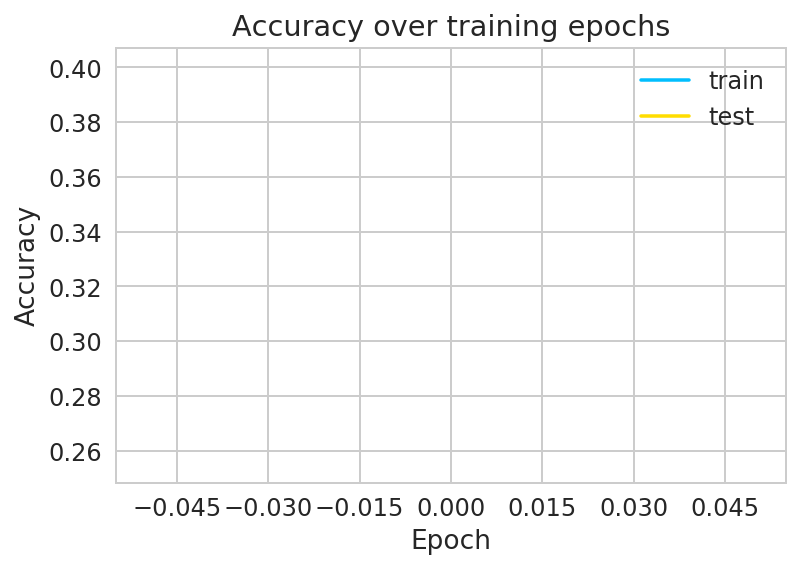

In [36]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Accuracy over training epochs')
plt.show();

In [37]:
_, train_acc = model.evaluate(features.train_x, features.train_y)
_, test_acc = model.evaluate(features.test_x, features.test_y)

print("train acc", train_acc)
print("test acc", test_acc)

4/4 [==============================] - 5s 1s/step - loss: 1.4525 - acc: 0.4400
train acc 0.4399999976158142
test acc 0.4399999976158142
4/4 [==============================] - 5s 1s/step - loss: 1.4525 - acc: 0.4400
train acc 0.4399999976158142
test acc 0.4399999976158142


In [38]:
y_pred = model.predict(features.test_x).argmax(axis=-1)

In [39]:
print(classification_report(features.test_y, y_pred)) #, target_names=classes))

              precision    recall  f1-score   support

           0       0.50      0.06      0.11        16
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00        29
           3       0.44      1.00      0.61        43
           4       0.00      0.00      0.00         6

   micro avg       0.44      0.44      0.44       100
   macro avg       0.19      0.21      0.14       100
weighted avg       0.27      0.44      0.28       100



/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.50      0.06      0.11        16
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00        29
           3       0.44      1.00      0.61        43
           4       0.00      0.00      0.00         6

   micro avg       0.44      0.44      0.44       100
   macro avg       0.19      0.21      0.14       100
weighted avg       0.27      0.44      0.28       100



/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [40]:
cm = confusion_matrix(features.test_y, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

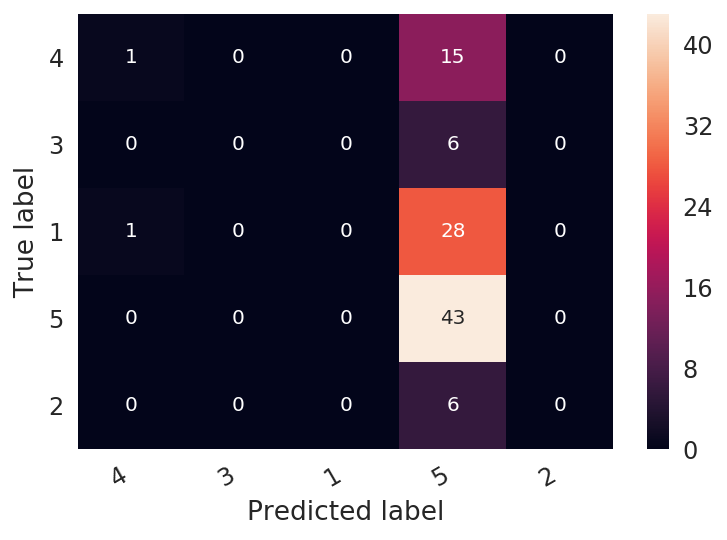

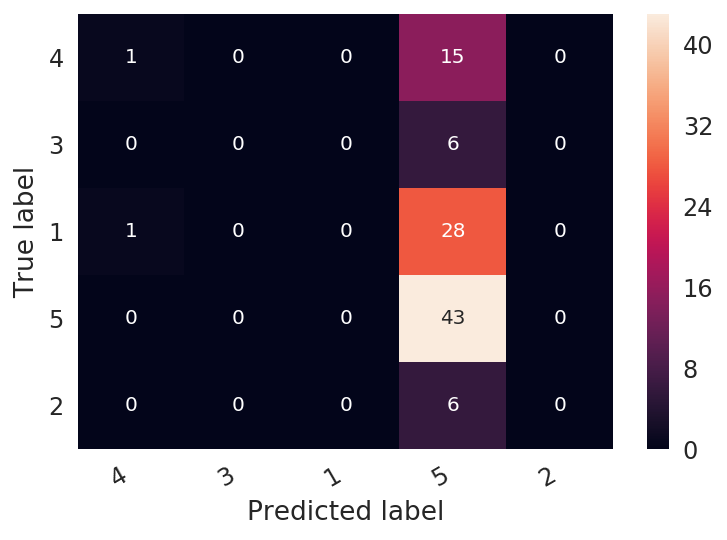

In [41]:
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [42]:
sentences = [
  "This is just OK.",
  "This sucks.",
  "This is great."
]

pred_tokens = map(tokenizer.tokenize, sentences)
pred_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))

pred_token_ids = map(lambda tids: tids +[0]*(features.max_seq_len-len(tids)),pred_token_ids)
pred_token_ids = np.array(list(pred_token_ids))

predictions = model.predict(pred_token_ids).argmax(axis=-1)

for review_body, star_rating in zip(sentences, predictions):
  print("review_body:", review_body, "\star_rating:", classes[star_rating])
  print()

review_body: This is just OK. \star_rating: 5

review_body: This sucks. \star_rating: 5

review_body: This is great. \star_rating: 5

review_body: This is just OK. \star_rating: 5

review_body: This sucks. \star_rating: 5

review_body: This is great. \star_rating: 5



# References

- https://www.kdnuggets.com/2020/02/intent-recognition-bert-keras-tensorflow.html
- https://mccormickml.com/2019/07/22/BERT-fine-tuning/
- https://github.com/snipsco/nlu-benchmark/tree/master/2017-06-custom-intent-engines
- https://jalammar.github.io/illustrated-bert/
- https://towardsdatascience.com/bert-for-dummies-step-by-step-tutorial-fb90890ffe03
- https://www.reddit.com/r/MachineLearning/comments/ao23cp/p_how_to_use_bert_in_kaggle_competitions_a/